In [24]:
# Imports and setup
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from pathlib import Path

root = Path.cwd().parent


In [25]:
# Load datasets
demand_df = pd.read_csv(root/'results'/'demand.csv').groupby('Date', as_index=False)['Sales'].sum()
shipment_decisions_df = pd.read_csv(root/'results'/'shipment_decisions.csv').groupby('Date', as_index=False)['Shipment'].sum()
inventory_decisions_df = pd.read_csv(root/'results'/'inventory_decisions.csv').groupby('Date', as_index=False)['Inventory'].sum()
shortage_decisions_df = pd.read_csv(root/'results'/'shortage_decisions.csv').groupby('Date', as_index=False)['Shortage'].sum()
holding_costs_df = pd.read_csv(root/'results'/'holding_costs.csv').groupby('Date', as_index=False)['HoldingCost'].sum()
shortage_penalties_df = pd.read_csv(root/'results'/'shortage_penalties.csv').groupby('Date', as_index=False)['ShortagePenalty'].sum()


In [26]:
# Compute actual sales from demand and shortage decisions
sales_df = demand_df.merge(shortage_decisions_df, on='Date', how='left')
sales_df['RealSales'] = sales_df['Sales'] - sales_df['Shortage']
sales_df = sales_df[['Date', 'RealSales']]
sales_df.rename(columns={'RealSales': 'Sales'}, inplace=True)


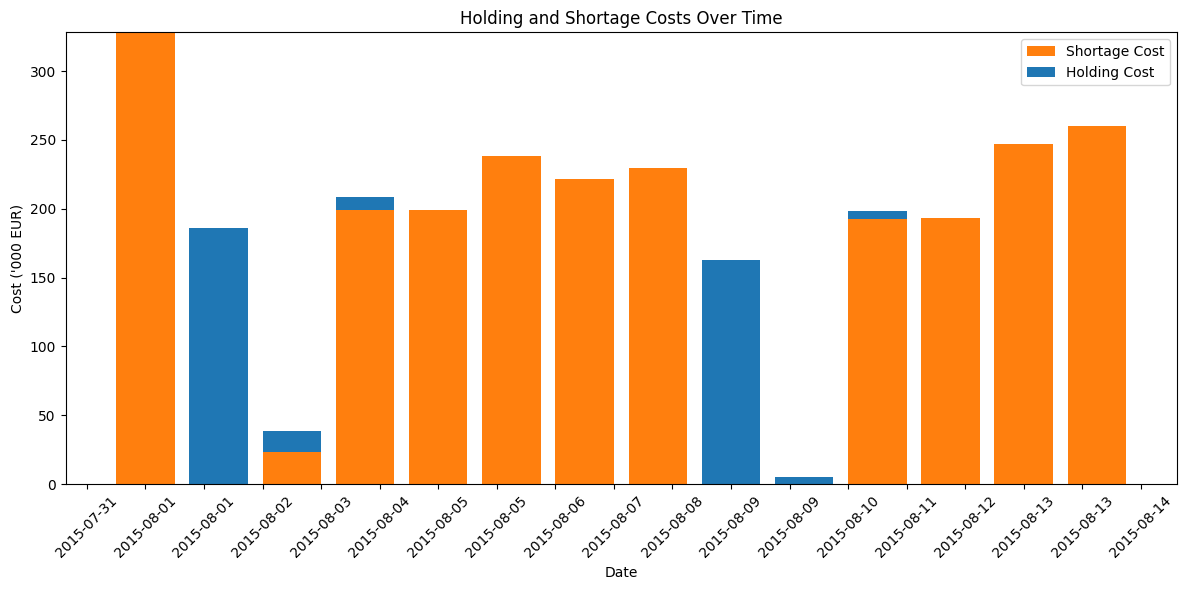

In [27]:
# Merge holding costs and shortage penalties on Date
costs_df = pd.merge(holding_costs_df, shortage_penalties_df, on='Date', how='inner')

# Make sure Date is datetime type
costs_df['Date'] = pd.to_datetime(costs_df['Date'])

dates = costs_df['Date']
holding_cost = costs_df['HoldingCost']
shortage_penalty = costs_df['ShortagePenalty']

plt.figure(figsize=(12, 6))

# Stacked bars
plt.bar(dates, shortage_penalty, label='Shortage Cost', color='#ff7f0e')
plt.bar(dates, holding_cost, bottom=shortage_penalty, label='Holding Cost', color='#1f77b4')

ax = plt.gca()

# Let matplotlib choose ~10 tick locations
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

# Format those ticks as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel("Cost ('000 EUR)")
plt.title('Holding and Shortage Costs Over Time')
plt.legend()
plt.tight_layout()
plt.show()


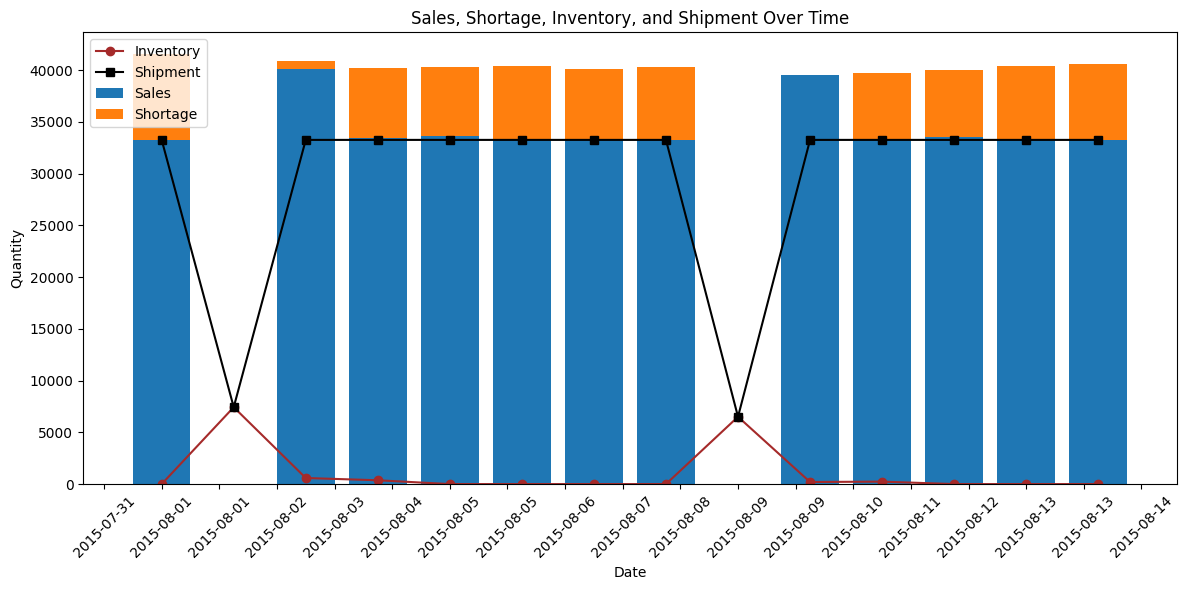

In [28]:
# Merge shortage and sales on Date
plot_df = pd.merge(shortage_decisions_df, sales_df, on='Date', how='inner')

dates = pd.to_datetime(plot_df['Date'])  # ensure datetime dtype
shortage = plot_df['Shortage']
sales = plot_df['Sales']

# Align inventory and shipment data by Date
inventory_plot_df = pd.merge(plot_df[['Date']], inventory_decisions_df, on='Date', how='left')
inventory = inventory_plot_df['Inventory']

shipment_plot_df = pd.merge(plot_df[['Date']], shipment_decisions_df, on='Date', how='left')
shipment = shipment_plot_df['Shipment']

plt.figure(figsize=(12, 6))

# Stacked bars: sales (blue bottom), shortage (orange top)
plt.bar(dates, sales, label='Sales', color='#1f77b4')
plt.bar(dates, shortage, bottom=sales, label='Shortage', color='#ff7f0e')

# Inventory as a brown line with circle markers
plt.plot(dates, inventory, label='Inventory', color='brown', marker='o')

# Shipment as a black line with square markers
plt.plot(dates, shipment, label='Shipment', color='black', marker='s')

ax = plt.gca()

# Limit number of x-axis ticks to ~10 to reduce clutter
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

# Format ticks as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Sales, Shortage, Inventory, and Shipment Over Time')
plt.legend()
plt.tight_layout()
plt.show()
